# Evaluating NWM Streamflow Predictions

In this notebook we will demonstrate how to fetch streamflow predictions from the NWM for a given area. We will also see how the predictions change over time, and use some simple operations to visualize their variation over time.

This notebook uses the Kerchunk Combined dataset generated by Azavea as part of the NOAA NWM work: https://github.com/azavea/noaa-hydro-data/pull/132

## Imports

First we import the libraries we'll need. PyNHD has useful wrappers around various web services that allow us to fetch hydrological data. S3FS and XArray are used to read NetCDF files from S3. SQL Alchemy and GeoPandas are used to construct dataframes from a PostGIS database.

In [27]:
from pynhd.pynhd import NHD, NHDPlusHR, WaterData
import os, s3fs, fsspec, json
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import sqlalchemy as sa

from datetime import datetime, timedelta

## Helper functions for flowline retrieval

These are two ways to get flowlines, either from the NHD web service using HyRiver's `pynhd` package, or from our database where we've ingested the same data. The NHD web service is more portable but slower.

In [28]:
def get_flowlines_from_db(huc):
    con = sa.create_engine(
        "{driver}://{user}:{password}@{host}/{database}".format(
            driver="postgresql+psycopg2",
            user=os.getenv("PGUSER"),
            password=os.getenv("PGPASSWORD"),
            host=os.getenv("PGHOST"),
            database="nhdplusv2",
        )
    )

    sql = f"""
        SELECT comid, shape
        FROM nhdflowline_network
        WHERE ST_Intersects(
            shape,
            ST_Transform(
                ST_SetSRID(
                    ST_GeomFromText('{huc.geometry[0].wkt}'),
                    4326),
                4269)
        )
    """
    
    return gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')

In [29]:
def get_flowlines_from_web(huc):
    return NHD('flowline_mr').bygeom(huc.geometry[0].geoms[0])

## Pick an Area of Interest

We want to look at streamflow predictions for a particular area. In this example, we're looking at the Lower Schuylkill HUC-10 `0204020310`.

CPU times: user 166 ms, sys: 10 ms, total: 176 ms
Wall time: 834 ms


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

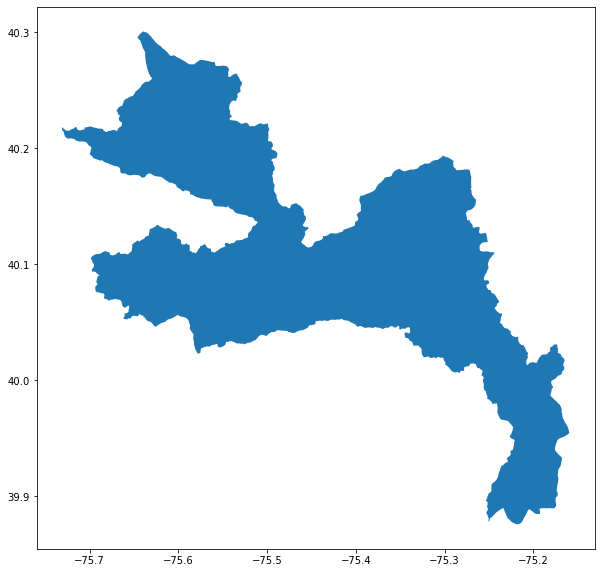

In [30]:
%%time

HUC = '0204020310'

huc = WaterData('wbd10_20201006').byid('huc10', HUC)
huc.geometry.plot(figsize=(10, 10))

Get flowlines contained within that shape

CPU times: user 183 ms, sys: 5.44 ms, total: 188 ms
Wall time: 101 ms


<AxesSubplot:>

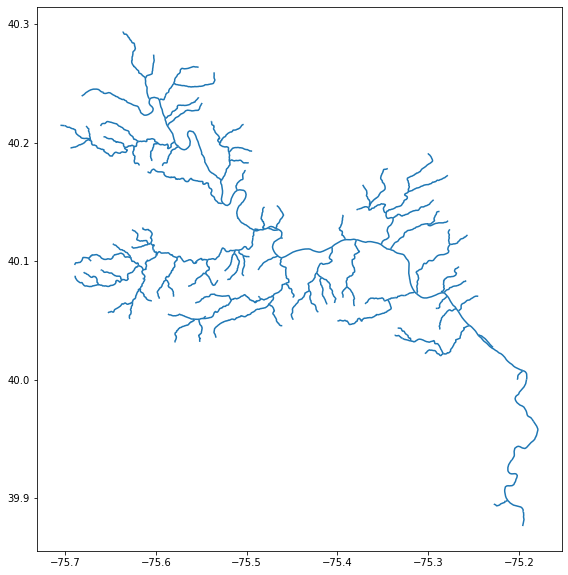

In [31]:
%%time

flowlines = get_flowlines_from_web(huc)
flowlines.plot(figsize=(10, 10))

## Fetch the NWM Short Range Forecast

We fetch the NWM Short Range forecast from the Zarr files available in our S3 bucket `azavea-noaa-hydro-data`, which allows credentialed access. For now, we only care about `streamflow`, so we drop the other variables.

In [32]:
%%time

fs = s3fs.S3FileSystem()

kerchunk_url = f's3://element84-noaa-nwm/public/nwm-combined-kerchunk.json'

with fs.open(kerchunk_url) as f:
    kerchunk = fsspec.get_mapper(
        'reference://',
        fo=json.load(f),
        remote_protocol='s3',
        remote_options={'anon': True})
        
ds = xr.open_dataset(kerchunk, engine='zarr', consolidated=False, chunks={})
ds

CPU times: user 614 ms, sys: 30.6 ms, total: 645 ms
Wall time: 1.95 s


<xarray.Dataset>
Dimensions:         (reference_time: 697, time: 713, feature_id: 2776738)
Coordinates:
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
  * reference_time  (reference_time) datetime64[ns] 2023-07-26T12:00:00 ... 2...
  * time            (time) datetime64[ns] 2023-07-26T14:00:00 ... 2023-08-25T...
Data variables:
    crs             (reference_time, time) object dask.array<chunksize=(1, 1), meta=np.ndarray>
    nudge           (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
    qBtmVertRunoff  (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
    qBucket         (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
    qSfcLatRunoff   (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
    streamflow      (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
    velocity        (reference_time, time, feature_id) float64 dask.array<chunksize=(1, 1, 2776738), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    NWM_version_number:         v2.2
    TITLE:                      OUTPUT FROM NWM v2.2
    cdm_datatype:               Station
    code_version:               v5.2.0-beta2
    dev:                        dev_ prefix indicates development/internal me...
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2023-07-26_14:00:00
    model_total_valid_times:    18
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

## Subset the dataset to only the streams within the HUC, for the last 3 days

The NHD COMID dataset and the NWM Feature IDs don't have an exact overlap. We intersect the two to limit our work to those streams found in both.

We also limit the request to the last 3 full days.

In [33]:
%%time

nhd_reaches = set([int(f) for f in flowlines['COMID']])
nwm_reaches = set(ds.feature_id.values)

common_reaches = list(set(nwm_reaches).intersection(set(nhd_reaches)))
len(common_reaches)

CPU times: user 273 ms, sys: 163 ms, total: 436 ms
Wall time: 434 ms


273

In [44]:
%%time

today = datetime.strptime('2023-08-24', '%Y-%m-%d')
time_range = slice(today - timedelta(days=5), today-timedelta(days=2))
time_range

CPU times: user 666 µs, sys: 0 ns, total: 666 µs
Wall time: 674 µs


slice(datetime.datetime(2023, 8, 19, 0, 0), datetime.datetime(2023, 8, 22, 0, 0), None)

Next we persist the subset to Dask. This optimization makes all the subsequent tasks much faster, since the data is saved to memory and reused.

In [45]:
%%time

sub_ds = ds.sel(reference_time=time_range).sel(time=time_range).sel(feature_id=common_reaches)
sub_da = sub_ds['streamflow']
sub_da = sub_da.persist()

CPU times: user 1min 35s, sys: 5.35 s, total: 1min 40s
Wall time: 2min 8s


In [41]:
sub_da

<xarray.DataArray 'streamflow' (reference_time: 0, time: 713, feature_id: 273)>
dask.array<getitem, shape=(0, 713, 273), dtype=float64, chunksize=(0, 1, 273), chunktype=numpy.ndarray>
Coordinates:
  * feature_id      (feature_id) int32 4782081 4782593 ... 4782589 4782591
  * reference_time  (reference_time) datetime64[ns] 
  * time            (time) datetime64[ns] 2023-07-26T14:00:00 ... 2023-08-25T...
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1
    valid_range:   [0, 5000000]

## Pick a single feature to analyze

For every feature, for every hour of the day, we have 18 forecast values, for a total of 432. At midnight there are forecasts for 1am, 2am, ..., 6pm, at 1am there are forecasts for 2am, 3am, ..., 7pm, and so on. To observe how these forecasts change with time, we pick a single representative feature to analyze.

Every feature has a `feature_id`. For this feature, there are 24 `reference_time`s, corresponding to the hour of the day. For each `reference_time`, there are 18 `time`s each, corresponding to the hour of the prediction.

CPU times: user 124 ms, sys: 6.22 ms, total: 130 ms
Wall time: 60 ms


/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<xarray.DataArray 'streamflow' (reference_time: 73, time: 73)>
dask.array<getitem, shape=(73, 73), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    feature_id      int32 4784835
  * reference_time  (reference_time) datetime64[ns] 2023-08-19 ... 2023-08-22
  * time            (time) datetime64[ns] 2023-08-19 ... 2023-08-22
Attributes:
    grid_mapping:  crs
    long_name:     River Flow
    units:         m3 s-1
    valid_range:   [0, 5000000]

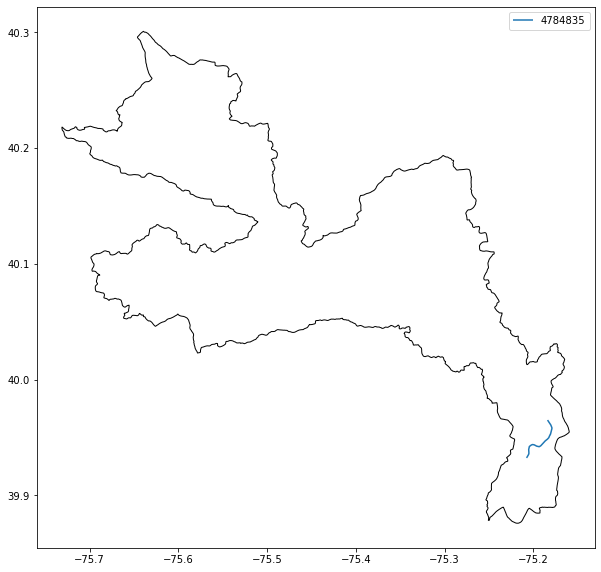

In [46]:
%%time

FEATURE_ID = 4784835

ax = huc.plot(facecolor="none", edgecolor="k", figsize=(10, 10))
flowlines[flowlines.COMID == FEATURE_ID].plot(ax=ax, label=FEATURE_ID)
ax.legend()

feature_da = sub_da.sel(feature_id=[FEATURE_ID]).squeeze()
feature_da

## Streamflow predicted for 3 days at each reference time

This visualization shows the predicted streamflow for the 3 days starting at each `reference_time`. The x-axis is `time`, and has multiple values for each `reference_time`. The y-axis is `streamflow`. Each line corresponds to a `reference_time`. This shows how the predictions change at each iteration.

CPU times: user 487 ms, sys: 60.5 ms, total: 547 ms
Wall time: 529 ms


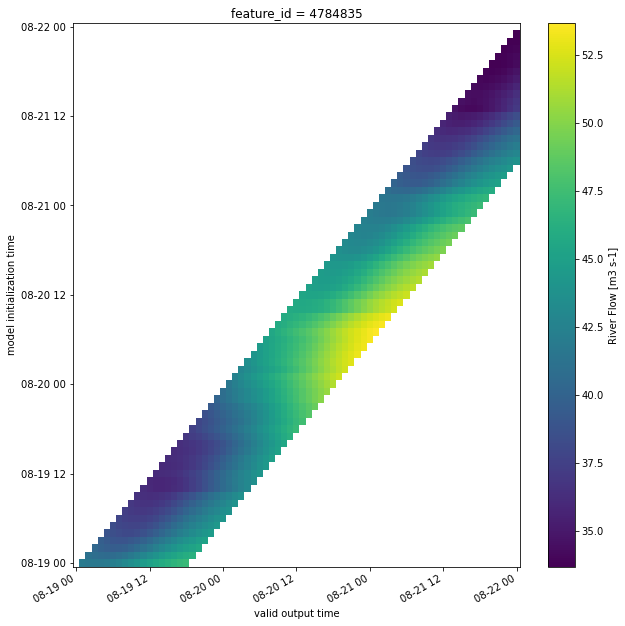

In [47]:
%%time

feature_da.plot(figsize=(10,10))

CPU times: user 804 ms, sys: 64.1 ms, total: 868 ms
Wall time: 846 ms


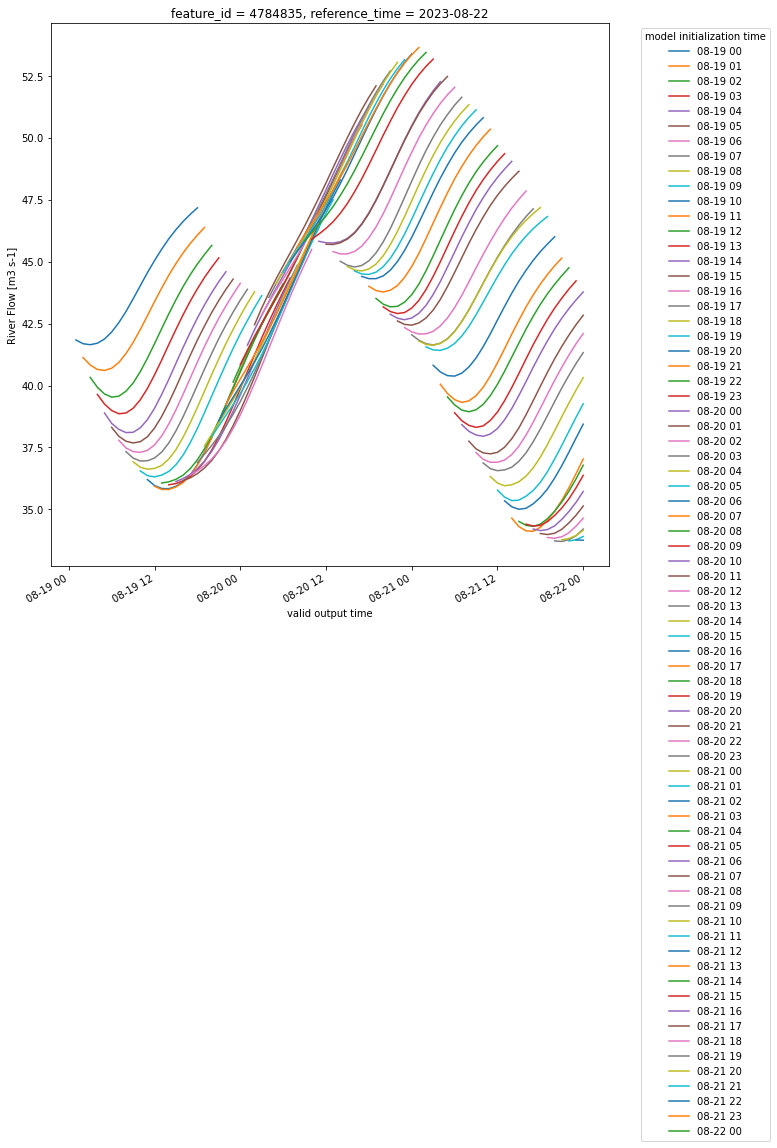

In [48]:
%%time

fig, ax = plt.subplots(figsize=(10, 10))

predictions = list(feature_da.groupby('reference_time'))
reference_times = []
for prediction in predictions:
    reference_times.append(prediction[0].astype('datetime64[us]').astype(datetime).strftime('%m-%d %H'))
    prediction[1].plot(ax=ax)
    
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=reference_times, title='model initialization time')

## Change in predicted streamflow for a given time

This is an inverse of the previous graph: each line corresponds to a `time`, and we see how it's prediction changes over different `reference_time`s.

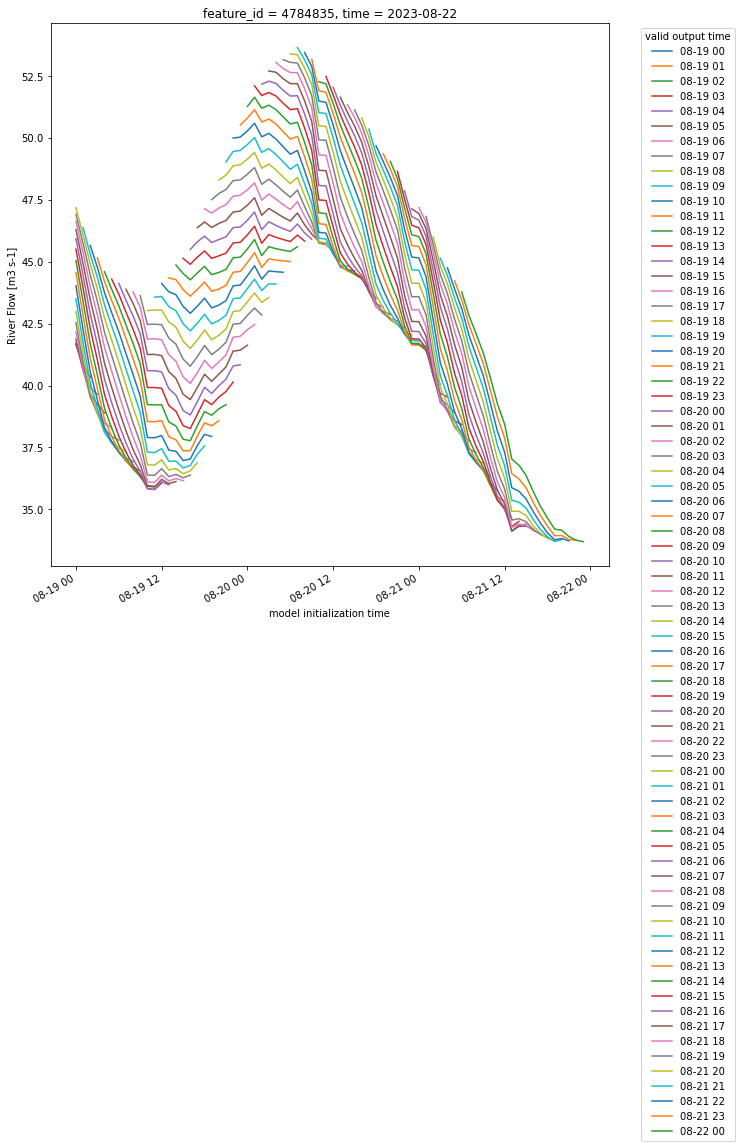

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

predictions = list(feature_da.groupby('time'))
times = []
for prediction in predictions:
    times.append(prediction[0].astype('datetime64[us]').astype(datetime).strftime('%m-%d %H'))
    prediction[1].plot(ax=ax)
    
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', labels=times, title='valid output time')

## Standard deviation of prediction by hour

Let's quantify that change by calculating the standard deviation by hour. The normal-ish curve seen below is explained by the fact that there are more predictions in the middle than there are on the edges.

/opt/conda/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


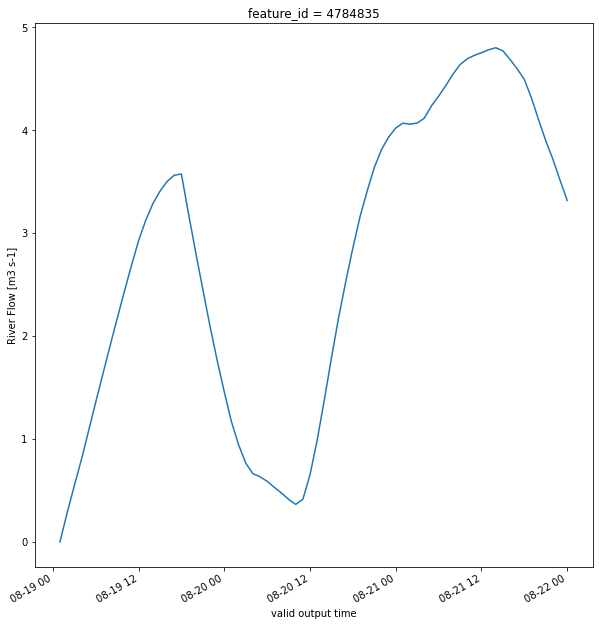

In [50]:
feature_da.groupby('time').std('reference_time').plot(figsize=(10, 10))

## Average deviation for this reach

In [51]:
feature_da.groupby('time').std('reference_time').mean().compute()

/opt/conda/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'streamflow' ()>
array(2.73691077)
Coordinates:
    feature_id  int32 4784835

## Average deviation for every reach in the HUC

Now that we have a scalar value for the reach, we can do the same calculation for every reach in the HUC. Once we have that distribution, we can also visualize it. In the visualization we see that reaches along the main stream have more variation than those on the edges. This makes sense: as the main stream has a lot of small streams contributing to it, so all their small variations add up to large ones.

CPU times: user 1.37 s, sys: 290 ms, total: 1.66 s
Wall time: 1.43 s


/opt/conda/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

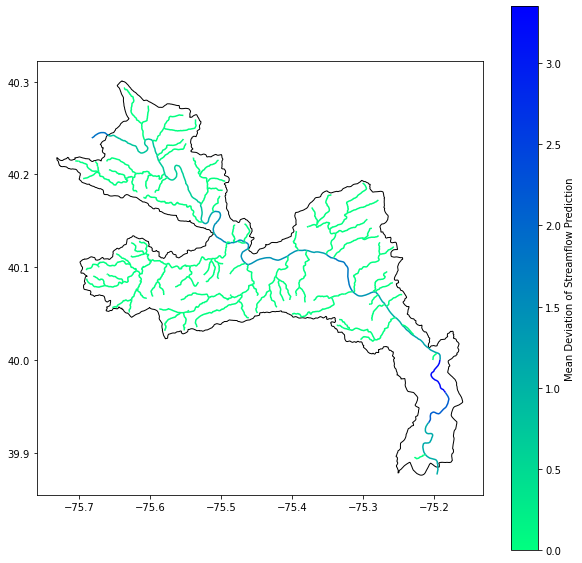

In [53]:
%%time

mean_std_per_reach = sub_da.std('time').mean('reference_time').to_dataframe()

joined = flowlines.merge(mean_std_per_reach, left_on='COMID', right_on='feature_id')

ax = huc.plot(facecolor="none", edgecolor="k", figsize=(10, 10))
joined.plot(ax=ax, column="streamflow", cmap='winter_r', legend=True, legend_kwds={"label": "Mean Deviation of Streamflow Prediction"})